In [63]:
from datasets.pamap2 import PAMAP2
from datasets.opportunity import Opportunity
from datasets.mmfit import MMFit
from datasets.motionsense import MotionSense
from datasets.mhealth import MHEALTH
from datasets.wisdm import WISDM

from models.cnn import CNN
from models.convlstm import ConvLSTM
from models.gru import GRU
from models.lstm import LSTM
from models.transformer import Transformer

import numpy as np
import csv
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import ast
import sys
from sklearn.metrics import f1_score


In [72]:
# DATASET LOOP
dir = './outputs/H100/'
DATASET_LIST = ['PAMAP2','OPPORTUNITY','MMFIT','MHEALTH','MOTIONSENSE','WISDM']
MODEL_LIST = ['CNN','CONVLSTM','GRU','LSTM','TRANSFORMER','CPC']

BATCH_LIST = [64, 256, 1024]
LR_LIST = [0.1, 0.01, 0.001]

WINDOW = 200
STRIDE = 100

STEP = 20
GAMMA = 0.5
PATIENCE = 40
NUM_EPOCHS = 200
best_rows = {}

for DATASET in DATASET_LIST:   
    # MODEL LOOP
    for MODEL in MODEL_LIST:
        print("\nDATASET: " + DATASET)
        print("MODEL: " + MODEL)

        best_accuracy = 0
        best_loss = float('inf')
        best_batch = 0
        best_lr = 0
        best_exp_id = []
        
       
        for BATCH in BATCH_LIST:
            for LR in LR_LIST:
                total_accuracy = 0
                total_loss = 0
                total_rows = 0
                exp_id = []
                rows = []
                with open(dir + DATASET+'_'+MODEL+'.csv', 'r') as csvfile:
                    csvreader = csv.reader(csvfile)
                    for row in csvreader:
                        if int(row[3]) == BATCH and float(row[4]) == LR:
                            #print(row)
                            
                            total_accuracy += float(row[8])
                            total_loss += float(row[9]) 
                            total_rows += 1
                            exp_id.append(row[0])
                            rows.append(row)
                
                # rows = sorted(rows, key=lambda x: x[5])
                # print(rows)
                average_accuracy = total_accuracy / total_rows if total_rows > 0 else 0
                #print(average_accuracy)
                average_loss = total_loss / total_rows if total_rows > 0 else float('inf')

                if average_accuracy > best_accuracy:
                    best_accuracy = average_accuracy
                    best_loss = average_loss
                    best_batch = BATCH
                    best_lr = LR
                    best_exp_id=exp_id
                    best_rows[(DATASET, MODEL)] = rows


        # Output the best batch size and learning rate
        print("Best Batch Size:", best_batch)
        print("Best Learning Rate:", best_lr)
        print("Best Accuracy:", best_accuracy)
        print("Best Loss:", best_loss)
        print("Best IDs:", best_exp_id)


# pprint(best_rows)
print(best_rows)
                   
                
            


DATASET: OPPORTUNITY
MODEL: CNN
Best Batch Size: 64
Best Learning Rate: 0.001
Best Accuracy: 0.7598911788342091
Best Loss: 0.850471854178454
Best IDs: ['8', '9', '10', '11']

DATASET: OPPORTUNITY
MODEL: CONVLSTM
Best Batch Size: 64
Best Learning Rate: 0.1
Best Accuracy: 0.7286171933657251
Best Loss: 1.2377302949568016
Best IDs: ['0', '1', '2', '3']

DATASET: OPPORTUNITY
MODEL: GRU
Best Batch Size: 256
Best Learning Rate: 0.01
Best Accuracy: 0.776489051896032
Best Loss: 0.814652874838147
Best IDs: ['16', '17', '18', '19']

DATASET: OPPORTUNITY
MODEL: LSTM
Best Batch Size: 64
Best Learning Rate: 0.001
Best Accuracy: 0.7558397508070182
Best Loss: 0.8775150151364957
Best IDs: ['8', '9', '10', '11']

DATASET: OPPORTUNITY
MODEL: TRANSFORMER
Best Batch Size: 64
Best Learning Rate: 0.001
Best Accuracy: 0.7955199687612593
Best Loss: 0.6734083706851267
Best IDs: ['8', '9', '10', '11']

DATASET: OPPORTUNITY
MODEL: CPC
Best Batch Size: 64
Best Learning Rate: 0.001
Best Accuracy: 0.756727644335779

In [65]:
WINDOW = 200
STRIDE = 100

# ds = PAMAP2(users=[2], window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
# print(len(ds))
# x_data= [ds[i][0][0][[1,2,3]] for i in range(0,len(ds))]
# x_data = [tensor.numpy() for tensor in x_data]
# x_data = np.vstack(x_data)
# print(x_data.shape)

In [73]:
import matplotlib.pyplot as plt

vectors, gt, predict, sensors = [], [], [], []

for dataset_id,DATASET in enumerate(DATASET_LIST):
    dataset_vectors, dataset_predict=  [],[]
    
    sensorLoader = 0
    for MODEL in MODEL_LIST:
        model_vectors, model_gt, model_predict, model_sensors = [], [], [], []
        
        for person in best_rows[DATASET, MODEL]:
            data = np.load(dir + DATASET + '_' + MODEL + '_' + person[0] + '.npz', allow_pickle=True)
            y = np.concatenate(data['y'])
            y= y.astype(int)
            outputs = np.concatenate(data['outputs'])
            max_outputs = np.argmax(outputs, axis=1)

            comparison = y != max_outputs
            result = comparison.astype(int)

            model_vectors.append(result)
            model_predict.append(outputs)
            # print(person[5])
            if sensorLoader==0:
                print(y[0])
                model_gt.append(y)

                
                if DATASET == 'PAMAP2':
                    print("PAMAP2")
                    indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]
                    ds = PAMAP2(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=WINDOW, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
                    print(WINDOW//2)
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:] for i in range(0,len(ds))]])
                    print(x_data.shape)
                    model_sensors.append(x_data)
                elif DATASET=='OPPORTUNITY':
                    print("OPPORTUNITY")
                    indices = [i for i in range(1, 37)]
                    ds = Opportunity(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=WINDOW)
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:] for i in range(0,len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MMFIT':
                    print("MMFIT")
                    indices = [0,1,2,6,7,8,12,13,14,18,19,20]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    usr_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
                    ds = MMFit(users=[usr_list[i] for i in ast.literal_eval(person[5])], window_size=WINDOW, window_step=WINDOW, frequency=50, columns=None, train_users=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:] for i in range(0,len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MHEALTH':
                    print("MHEALTH")
                    indices = [i for i in range(0, 21)]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MHEALTH(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=WINDOW, train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:] for i in range(0,len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MOTIONSENSE':
                    print("MOTIONSENSE")
                    indices = [i for i in range(0, 12)]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MotionSense(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=WINDOW, train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:] for i in range(0,len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET=='WISDM':
                    print("WISDM")
                    indices = [i for i in range(0, 3)]
                    ds = WISDM(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=WINDOW,train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:] for i in range(0,len(ds))]])
                    model_sensors.append(x_data)
                else:
                    print("Wrong DATASET")
                    sys.exit(0)

        
        dataset_vectors.append(model_vectors)
        dataset_predict.append(model_predict)
        # dataset_gt.append(model_gt)
        if sensorLoader==0:
            sensors.append(model_sensors)
            gt.append(model_gt)
            sensorLoader = 1
    
    print("F1 Scores")
    for pred in dataset_predict:
        concatenated_true = [item for sublist in gt[dataset_id] for item in sublist]
        concatenated_pred = [item for sublist in pred for item in sublist]
        concatenated_true = np.array(concatenated_true)
        concatenated_pred = np.array(concatenated_pred)
        print(f1_score(concatenated_true, np.argmax(concatenated_pred, axis=1), average='weighted'))
    
    vectors.append(dataset_vectors)
    predict.append(dataset_predict)

data = []
for dataset_id,DATASET in enumerate(DATASET_LIST):
    data.append([])
    for person_id, person in enumerate(best_rows[DATASET, 'CNN']):
        data[dataset_id].append([])

        result_sum = np.sum((vectors[dataset_id][i][person_id] for i in range(0,len(vectors[dataset_id]))),dtype=int)
        max_val = np.max(result_sum)  
        vec = np.zeros_like(result_sum)
        vec[result_sum == max_val] = 1 
        temp = []
        for model in range(0,len(MODEL_LIST)):
            temp.append(predict[dataset_id][model][person_id])
        
        temp = np.array(temp)
        y_mean = np.mean(temp, axis=0)
        # print(y_mean.shape)
        y_classes = np.argmax(y_mean, axis=1)
        y = np.where(vec == 1, y_classes, gt[dataset_id][person_id])
        data[dataset_id][person_id] = {'x':sensors[dataset_id][person_id],'y':y,'gt':gt[dataset_id][person_id],'pid':person[5],'vec':vec}



    
    
# pprint(data)

0
OPPORTUNITY
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Dataset dir: /Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset/OpportunityChallengeLabeled
mean-std: None
Users: 1
X-y, user file: (255, 200, 114) (255,) /Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset/OpportunityChallengeLabeled/S1-ADL1.dat
X-y, user file: (161, 200, 114) (161,) /Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset/OpportunityChallengeLabeled/S1-ADL2.dat
X-y, user file: (166, 200, 114) (166,) /Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset/OpportunityChallengeLabeled/S1-ADL3.dat
X-y, user file: (164, 200, 114) (164,) /Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset/OpportunityChallengeLabeled/S1-ADL4.dat
X-y, user file: (150, 200, 114) (150,) /Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset/OpportunityChallengeLabeled/S1-ADL5

/var/folders/wd/jp3qk8gd7j9gb75gs1y7z_2c0000gp/T/ipykernel_5736/181332729.py:102: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  result_sum = np.sum((vectors[dataset_id][i][person_id] for i in range(0,len(vectors[dataset_id]))),dtype=int)


In [74]:
for dataset in range(0,len(data)):
    vec = np.array([])
    for person in range(0,len(data[dataset])):
        vec = np.append(vec,data[dataset][person]["vec"])
    print(np.count_nonzero(vec == 1))
    print(len(vec))

1041
8638


8159
[0, 12300, 13700, 59400, 60700, 73300, 74500, 118200, 118300, 118800, 119100, 122000, 122300, 122600, 123700, 134000, 134400, 134600, 135200, 143200, 144100, 144400, 145000, 145100, 146500, 147200, 171100, 171200, 173500, 173600, 174300, 174500, 174700, 175300, 175800, 176200, 176700, 176800, 178800, 179300, 179500, 179800, 180300, 180500, 181100, 181300, 183500, 183800, 184800, 184900, 186100, 186300, 186400, 186700, 186800, 187000, 187400, 187700, 188000, 188300, 188500, 189000, 189100, 189400, 190600, 191000, 191200, 191300, 192400, 192500, 192700, 193000, 193200, 193300, 193600, 193700, 194000, 194500, 195700, 195900, 196000, 196400, 197100, 197200, 197300, 197400, 198400, 198700, 199300, 199400, 199900, 200300, 201000, 201100, 201200, 201300, 201600, 202000, 203800, 203900, 204000, 204100, 204200, 204300, 204400, 204500, 204700, 205100, 205200, 205400, 206400, 206600, 206700, 206900, 207100, 207300, 207500, 208300, 209600, 210000, 210100, 210200, 211000, 211100, 212400, 21280

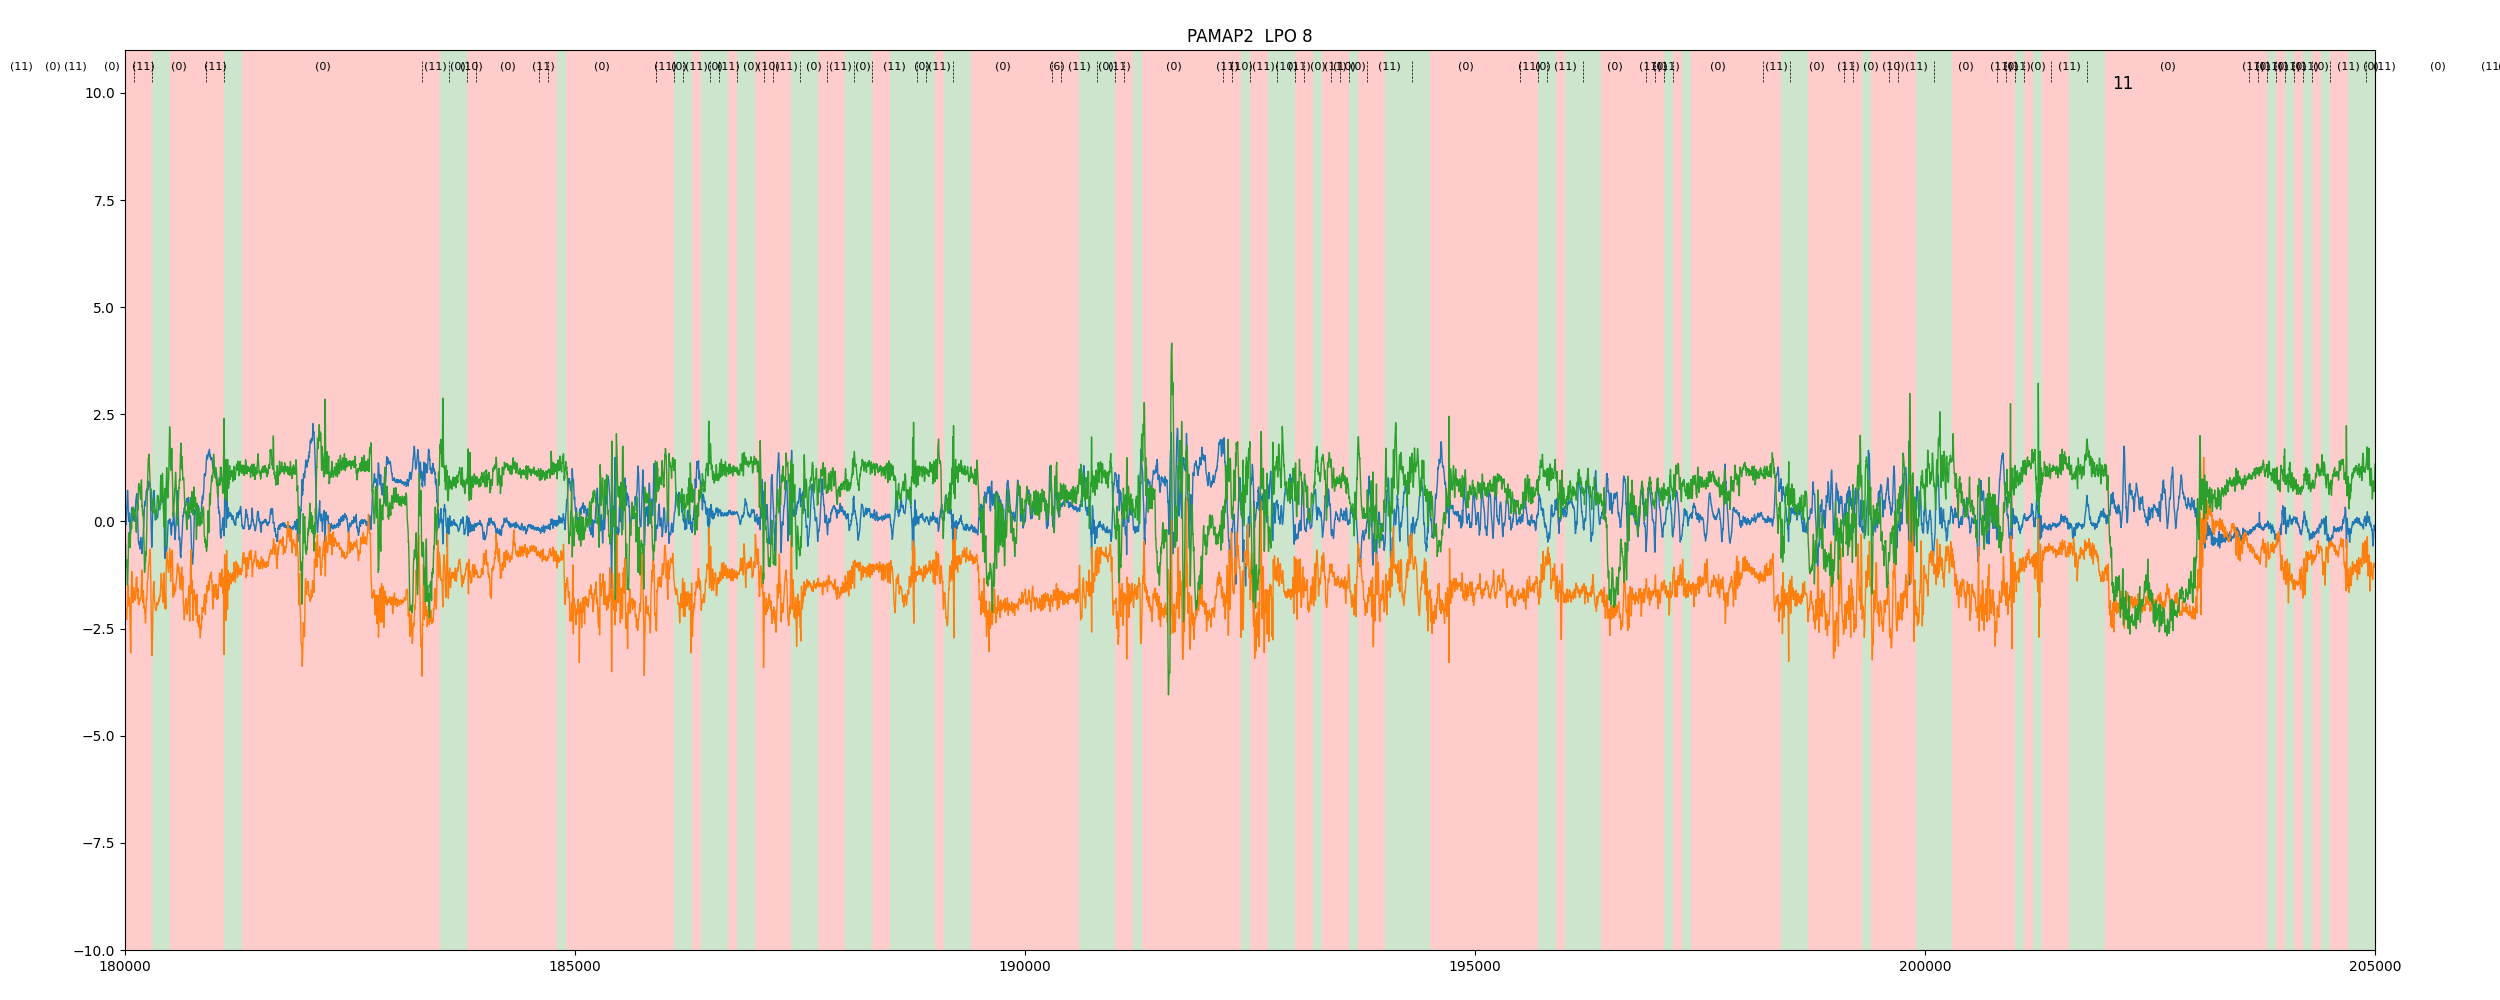

In [68]:
# CLASSIC

%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
DATASET = 0
PARTICIPANT = 1

vis_data = data[DATASET][PARTICIPANT]
# print(len(sensors))
# result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

# plt.bar(range(0,len(result_sum)),result_sum, width=1)

# plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


plt.figure(figsize=(25, 10))
# max_val = np.max(result_sum)  
# all_models = np.zeros_like(result_sum)
# all_models[result_sum == max_val] = 1  

segment_starts = []
segment_ends = []

vectors = vis_data["vec"]
print(len(vectors))
current_start = 0
values = []
values.append(vectors[0])
for i in range(1, len(vectors)):
    if vectors[i] != vectors[i -1]:
        segment_starts.append(current_start)
        segment_ends.append((i+1)*WINDOW//2)
        current_start = (i+1)*WINDOW//2
        values.append(vectors[i])

segment_starts.append(current_start)
segment_ends.append((len(vectors) -1)*WINDOW//2)
print(segment_starts)
print(segment_ends)
print(values)
colors = ['green' if x == 0 else 'red' for x in values]
for start, end, color in zip(segment_starts, segment_ends, colors):
    # plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
    plt.axvspan(start, end, facecolor=color, alpha=0.2)
    # if 'complete' not in model_labels_added:
    #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
    #     model_labels_added.add('complete')

gt = vis_data['gt']
previous = 0
for i in range(len(gt) - 1):
    if gt[i] != gt[i + 1] or i ==len(gt)-2:
        plt.axvline(x=i*WINDOW//2, color='black', linestyle='--', linewidth=0.5)
        plt.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 10, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
        previous = i*WINDOW//2

y = vis_data['y']
# pprint(y[0:100])
# pprint(vectors[0:100])
# pprint(gt[0:100])
previous = 0
for i in range(len(y) - 1):
    if y[i] != y[i + 1]:
        plt.vlines(x=i*WINDOW//2,ymin=10.25,ymax=10.75, color='black', linestyle='--', linewidth=0.5)
        plt.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 10.5, f"({y[i]})", va='bottom', ha='center', color='black', fontsize=8)
        previous = i*WINDOW//2

x = vis_data['x']

#PAMAP2
#indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]# acc
#indices = [3, 4, 5, 16, 17, 18, 29, 30, 31]# gyr
#indices = [6, 7, 8, 19, 20, 21, 32, 33, 34]# mag

plt.plot(range(0, len(x)), x[:,indices], linewidth=1)

plt.ylim(-10,11)
#plt.xlim(170000,195000)
plt.xlim(180000,205000)
plt.title(str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
# plt.savefig(f'images/window_view_{DATASET_LIST[DATASET]}_example.png',bbox_inches='tight')
plt.show()

8159
[0, 12300, 13700, 59400, 60700, 73300, 74500, 118200, 118300, 118800, 119100, 122000, 122300, 122600, 123700, 134000, 134400, 134600, 135200, 143200, 144100, 144400, 145000, 145100, 146500, 147200, 171100, 171200, 173500, 173600, 174300, 174500, 174700, 175300, 175800, 176200, 176700, 176800, 178800, 179300, 179500, 179800, 180300, 180500, 181100, 181300, 183500, 183800, 184800, 184900, 186100, 186300, 186400, 186700, 186800, 187000, 187400, 187700, 188000, 188300, 188500, 189000, 189100, 189400, 190600, 191000, 191200, 191300, 192400, 192500, 192700, 193000, 193200, 193300, 193600, 193700, 194000, 194500, 195700, 195900, 196000, 196400, 197100, 197200, 197300, 197400, 198400, 198700, 199300, 199400, 199900, 200300, 201000, 201100, 201200, 201300, 201600, 202000, 203800, 203900, 204000, 204100, 204200, 204300, 204400, 204500, 204700, 205100, 205200, 205400, 206400, 206600, 206700, 206900, 207100, 207300, 207500, 208300, 209600, 210000, 210100, 210200, 211000, 211100, 212400, 21280

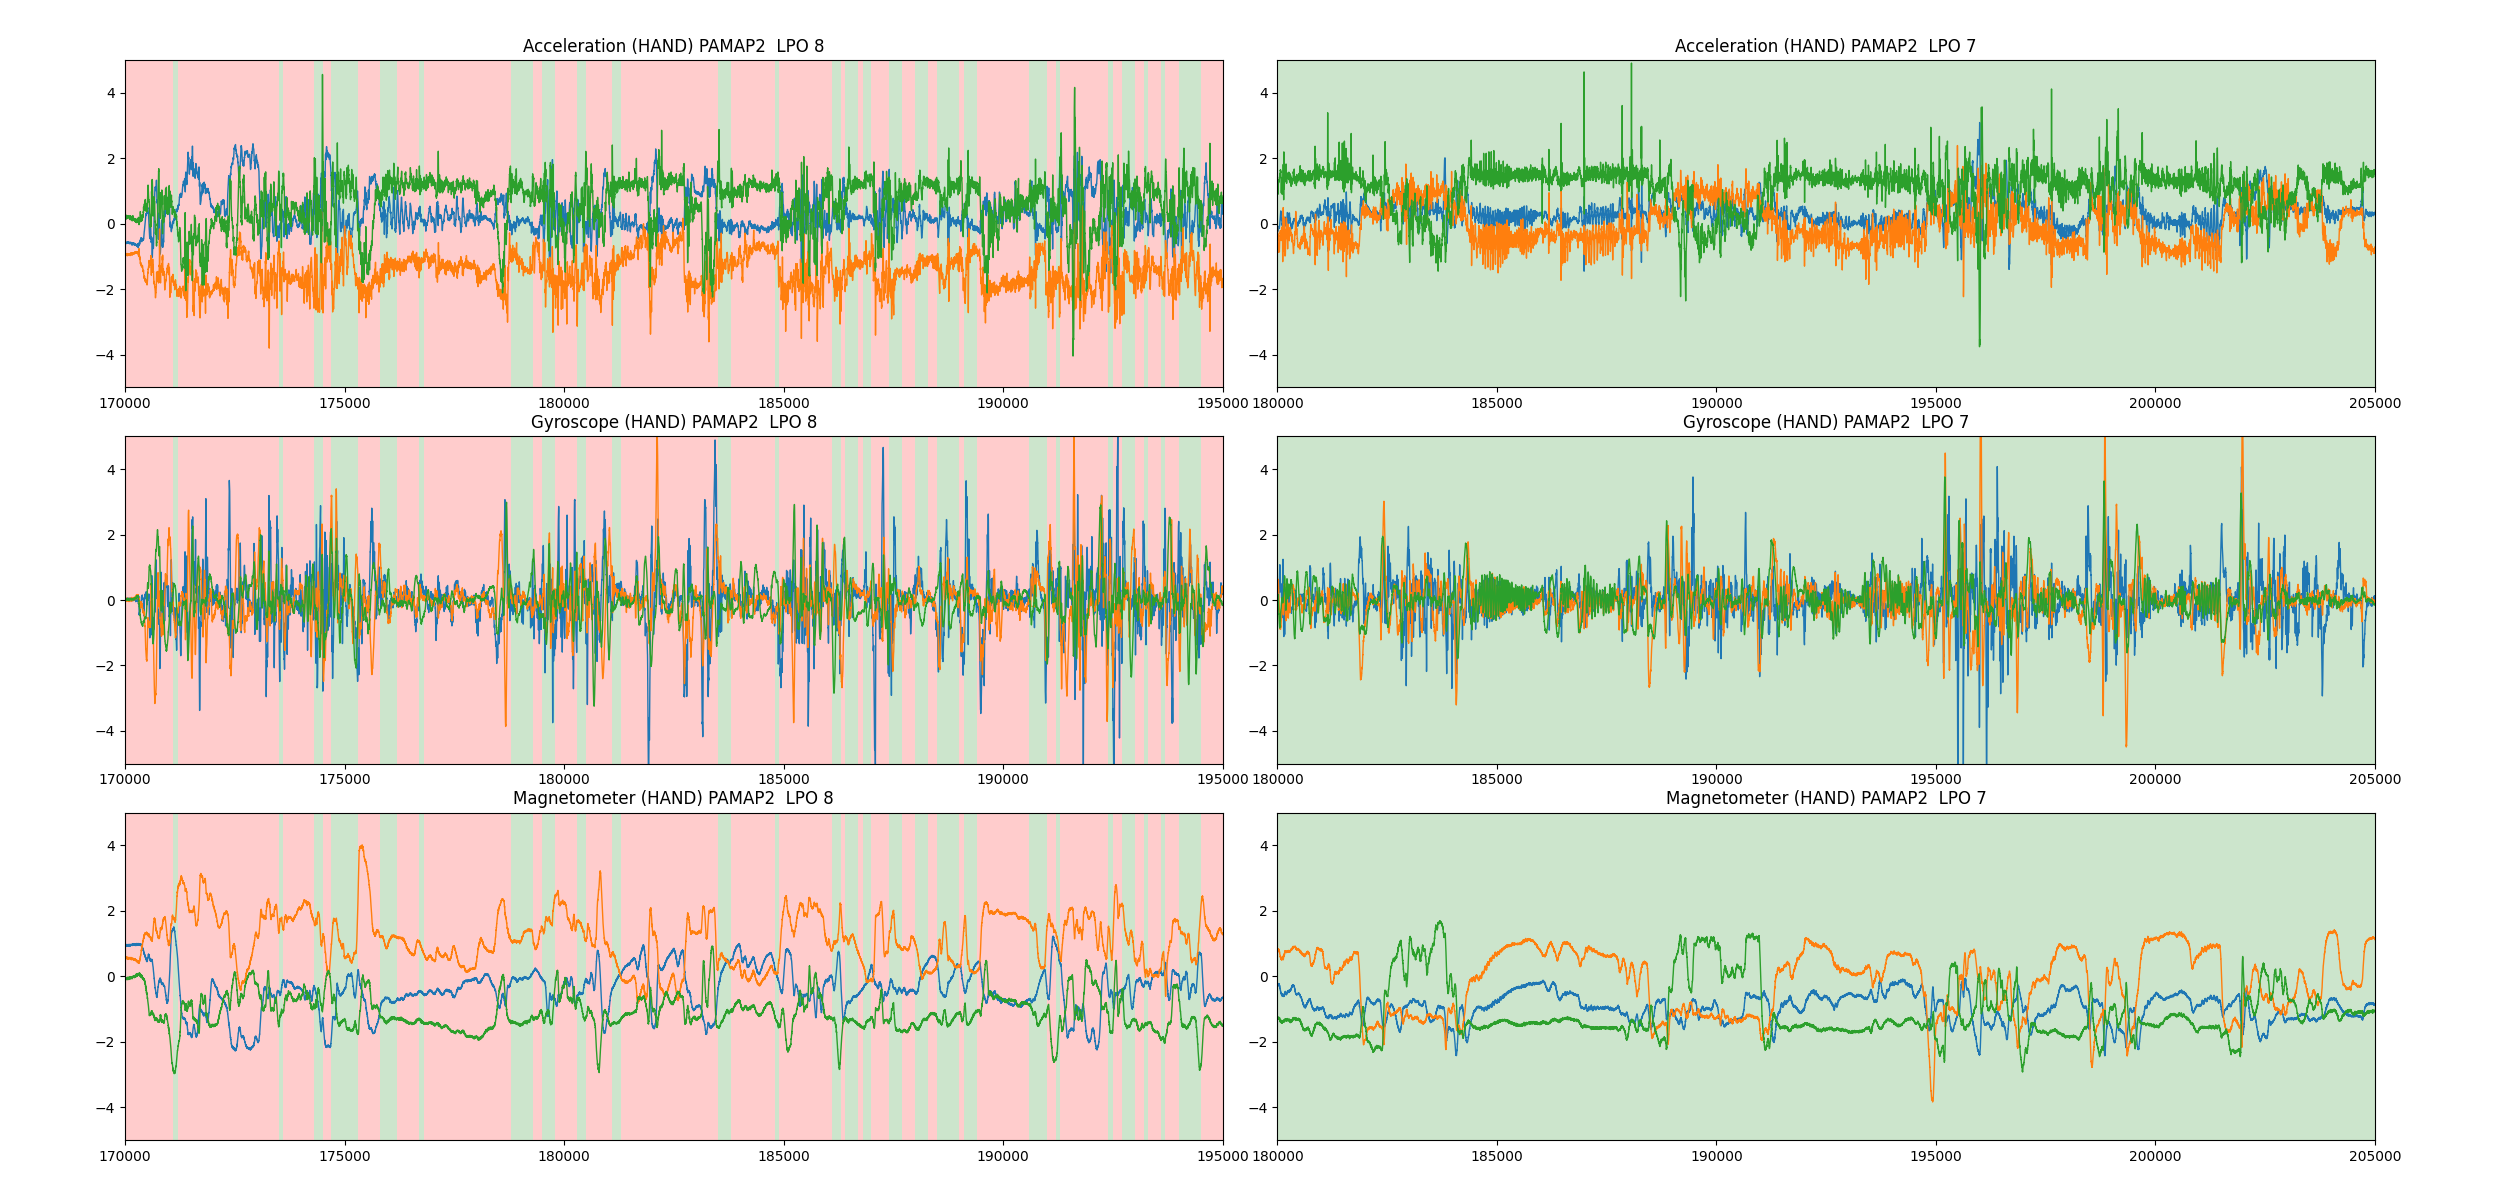

In [69]:
# PAMAP2 QUality

%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
fig, axs = plt.subplots(3,2, figsize=(25, 12))

for ax_id,ax in enumerate(axs.flatten()):
    if ax_id in [0,2,4]:
        DATASET = 0
        PARTICIPANT = 1
    else:
        DATASET = 0
        PARTICIPANT = 6
    vis_data = data[DATASET][PARTICIPANT]
    # print(len(sensors))
    # result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

    # plt.bar(range(0,len(result_sum)),result_sum, width=1)

    # plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


    
    # max_val = np.max(result_sum)  
    # all_models = np.zeros_like(result_sum)
    # all_models[result_sum == max_val] = 1  

    segment_starts = []
    segment_ends = []

    vectors = vis_data["vec"]
    print(len(vectors))
    current_start = 0
    values = []
    values.append(vectors[0])
    for i in range(1, len(vectors)):
        if vectors[i] != vectors[i -1]:
            segment_starts.append(current_start)
            segment_ends.append((i+1)*WINDOW//2)
            current_start = (i+1)*WINDOW//2
            values.append(vectors[i])

    segment_starts.append(current_start)
    segment_ends.append((len(vectors) -1)*WINDOW//2)
    print(segment_starts)
    print(segment_ends)
    print(values)
    colors = ['green' if x == 0 else 'red' for x in values]
    for start, end, color in zip(segment_starts, segment_ends, colors):
        # plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
        ax.axvspan(start, end, facecolor=color, alpha=0.2)
        # if 'complete' not in model_labels_added:
        #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
        #     model_labels_added.add('complete')

    gt = vis_data['gt']
    previous = 0
    for i in range(len(gt) - 1):
        if gt[i] != gt[i + 1] or i ==len(gt)-2:
            #ax.axvline(x=i*WINDOW//2, color='black', linestyle='--', linewidth=0.5)
            #ax.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 10, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
            previous = i*WINDOW//2

    y = vis_data['y']
    # pprint(y[0:100])
    # pprint(vectors[0:100])
    # pprint(gt[0:100])
    previous = 0
    for i in range(len(y) - 1):
        if y[i] != y[i + 1]:
            #ax.vlines(x=i*WINDOW//2,ymin=10.25,ymax=10.75, color='black', linestyle='--', linewidth=0.5)
            #ax.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 10.5, f"({y[i]})", va='bottom', ha='center', color='black', fontsize=8)
            previous = i*WINDOW//2

    x = vis_data['x']

    #PAMAP2
    if ax_id== 0 or ax_id==1:
        indices = [0, 1, 2,]# acc
        ax.set_title("Acceleration (HAND)"+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
    elif ax_id== 2 or ax_id==3:
        indices = [3, 4, 5, ]# gyr
        ax.set_title("Gyroscope (HAND)"+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
    else:
        indices = [6, 7, 8, ]# mag
        ax.set_title("Magnetometer (HAND)"+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))

    ax.plot(range(0, len(x)), x[:,indices], linewidth=1)
    
    ax.set_ylim(-5,5)
    if ax_id in [0,2,4]:
        ax.set_xlim(170000,195000)
    else:
        ax.set_xlim(180000,205000)
    
    



plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.15, wspace=0.05)
plt.savefig(f'images/data_view_{DATASET_LIST[DATASET]}_ironing.png',bbox_inches='tight')
plt.show()

1166
[0, 40100, 40200, 50400, 50700, 53800, 54100, 57300, 57400, 60500, 60600, 62400, 62500, 62600, 62800, 62900, 65100, 65200, 65400, 65500, 65700, 65800, 65900, 66000, 66500, 68300, 68500, 71800, 71900, 72000, 72100, 73600, 73700, 77300, 77400, 78300, 78600, 78700, 79100, 79400, 79600, 79700, 79900, 80000, 80100, 80300, 80400, 80600, 80800, 80900, 81100, 81200, 81300, 81400, 81500, 81700, 82000, 83800, 83900, 84000, 84100, 87200, 87500, 87600, 87700, 97800, 98200, 103700, 104100, 108000, 108100, 111200, 111400]
[40100, 40200, 50400, 50700, 53800, 54100, 57300, 57400, 60500, 60600, 62400, 62500, 62600, 62800, 62900, 65100, 65200, 65400, 65500, 65700, 65800, 65900, 66000, 66500, 68300, 68500, 71800, 71900, 72000, 72100, 73600, 73700, 77300, 77400, 78300, 78600, 78700, 79100, 79400, 79600, 79700, 79900, 80000, 80100, 80300, 80400, 80600, 80800, 80900, 81100, 81200, 81300, 81400, 81500, 81700, 82000, 83800, 83900, 84000, 84100, 87200, 87500, 87600, 87700, 97800, 98200, 103700, 104100, 10

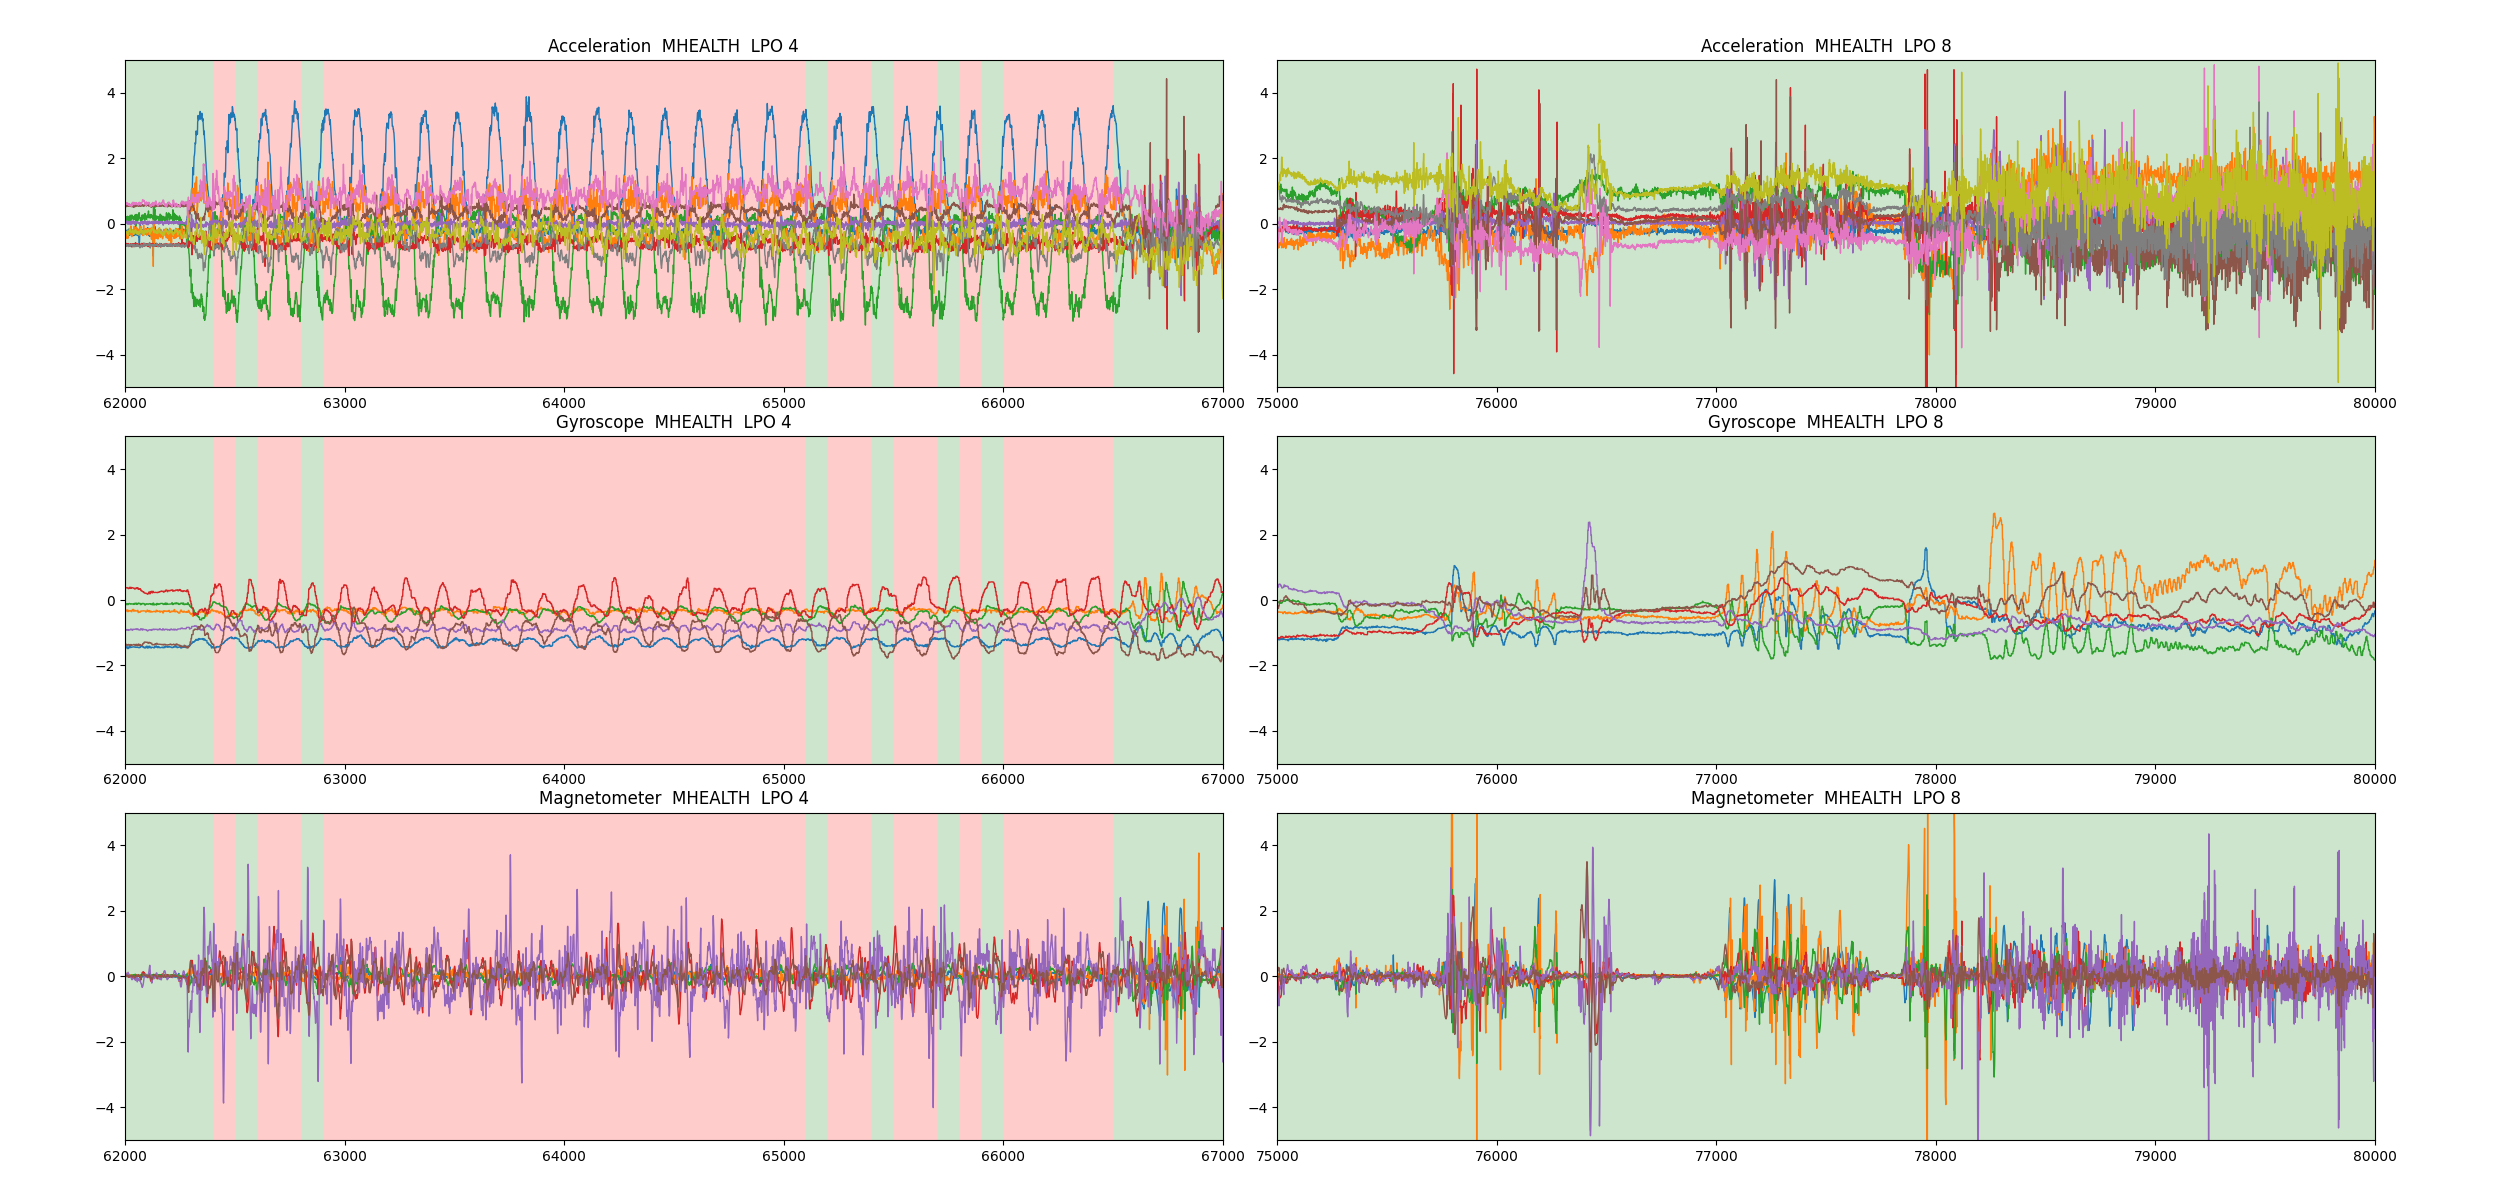

In [70]:
# MHEALTH Quality NULL CLASS

%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
fig, axs = plt.subplots(3,2, figsize=(25, 12))

for ax_id,ax in enumerate(axs.flatten()):
    if ax_id in [0,2,4]:
        DATASET = 3
        PARTICIPANT = 6
    else:
        DATASET = 3
        PARTICIPANT = 3
    vis_data = data[DATASET][PARTICIPANT]
    # print(len(sensors))
    # result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

    # plt.bar(range(0,len(result_sum)),result_sum, width=1)

    # plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


    
    # max_val = np.max(result_sum)  
    # all_models = np.zeros_like(result_sum)
    # all_models[result_sum == max_val] = 1  

    segment_starts = []
    segment_ends = []

    vectors = vis_data["vec"]
    print(len(vectors))
    current_start = 0
    values = []
    values.append(vectors[0])
    for i in range(1, len(vectors)):
        if vectors[i] != vectors[i -1]:
            segment_starts.append(current_start)
            segment_ends.append((i+1)*WINDOW//2)
            current_start = (i+1)*WINDOW//2
            values.append(vectors[i])

    segment_starts.append(current_start)
    segment_ends.append((len(vectors) -1)*WINDOW//2)
    print(segment_starts)
    print(segment_ends)
    print(values)
    colors = ['green' if x == 0 else 'red' for x in values]
    for start, end, color in zip(segment_starts, segment_ends, colors):
        # plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
        ax.axvspan(start, end, facecolor=color, alpha=0.2)
        # if 'complete' not in model_labels_added:
        #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
        #     model_labels_added.add('complete')

    gt = vis_data['gt']
    previous = 0
    for i in range(len(gt) - 1):
        if gt[i] != gt[i + 1] or i ==len(gt)-2:
            #ax.axvline(x=i*WINDOW//2, color='black', linestyle='--', linewidth=0.5)
            #ax.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 10, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
            previous = i*WINDOW//2

    y = vis_data['y']
    # pprint(y[0:100])
    # pprint(vectors[0:100])
    # pprint(gt[0:100])
    previous = 0
    for i in range(len(y) - 1):
        if y[i] != y[i + 1]:
            #ax.vlines(x=i*WINDOW//2,ymin=10.25,ymax=10.75, color='black', linestyle='--', linewidth=0.5)
            #ax.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 10.5, f"({y[i]})", va='bottom', ha='center', color='black', fontsize=8)
            previous = i*WINDOW//2

    x = vis_data['x']

    #PAMAP2
    if ax_id== 0 or ax_id==1:
        
        indices = [0,1,2,3,4,5,12,13,14]# acc
        ax.set_title("Acceleration "+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
    elif ax_id== 2 or ax_id==3:
        indices = [6,7,8,15,16,17]# gyr
        ax.set_title("Gyroscope "+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
    else:
        indices = [9,10,11,18,19,20]# mag
        ax.set_title("Magnetometer "+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))

    ax.plot(range(0, len(x)), x[:,indices], linewidth=1)
    
    ax.set_ylim(-5,5)
    if ax_id in [0,2,4]:
        ax.set_xlim(62000,67000)
    else:
        ax.set_xlim(75000,80000)
    
    



plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.15, wspace=0.05)
plt.savefig(f'images/data_view_{DATASET_LIST[DATASET]}_null.png',bbox_inches='tight')
plt.show()

7235
[0, 200, 900, 3100, 3800, 16500, 17400, 19200, 20700, 64400, 64500, 64900, 65900, 76600, 77800, 78000, 78200, 128300, 128400, 137600, 139500, 140500, 140600, 143200, 143400, 144600, 144800, 144900, 145100, 145300, 145400, 146600, 146800, 147100, 147200, 151100, 151200, 151300, 151400, 154100, 154200, 158500, 158900, 159700, 160400, 161000, 171400, 172200, 172300, 204500, 204600, 247700, 247800, 250200, 250300, 250400, 250500, 250700, 250800, 251800, 251900, 261800, 262900, 263600, 263700, 267800, 268000, 270300, 270500, 271300, 271600, 272000, 272200, 274600, 274700, 275800, 275900, 276500, 276600, 276800, 277000, 278300, 278600, 280400, 280500, 286100, 286200, 286700, 287000, 288100, 288200, 290300, 290600, 290700, 291300, 291600, 292200, 293900, 294000, 297300, 297400, 297500, 297600, 302500, 302700, 303500, 304000, 321600, 322300, 323000, 323100, 323600, 324100, 324300, 324400, 325200, 325600, 326100, 326400, 326500, 326600, 330600, 331500, 333200, 333300, 341100, 341200, 34160

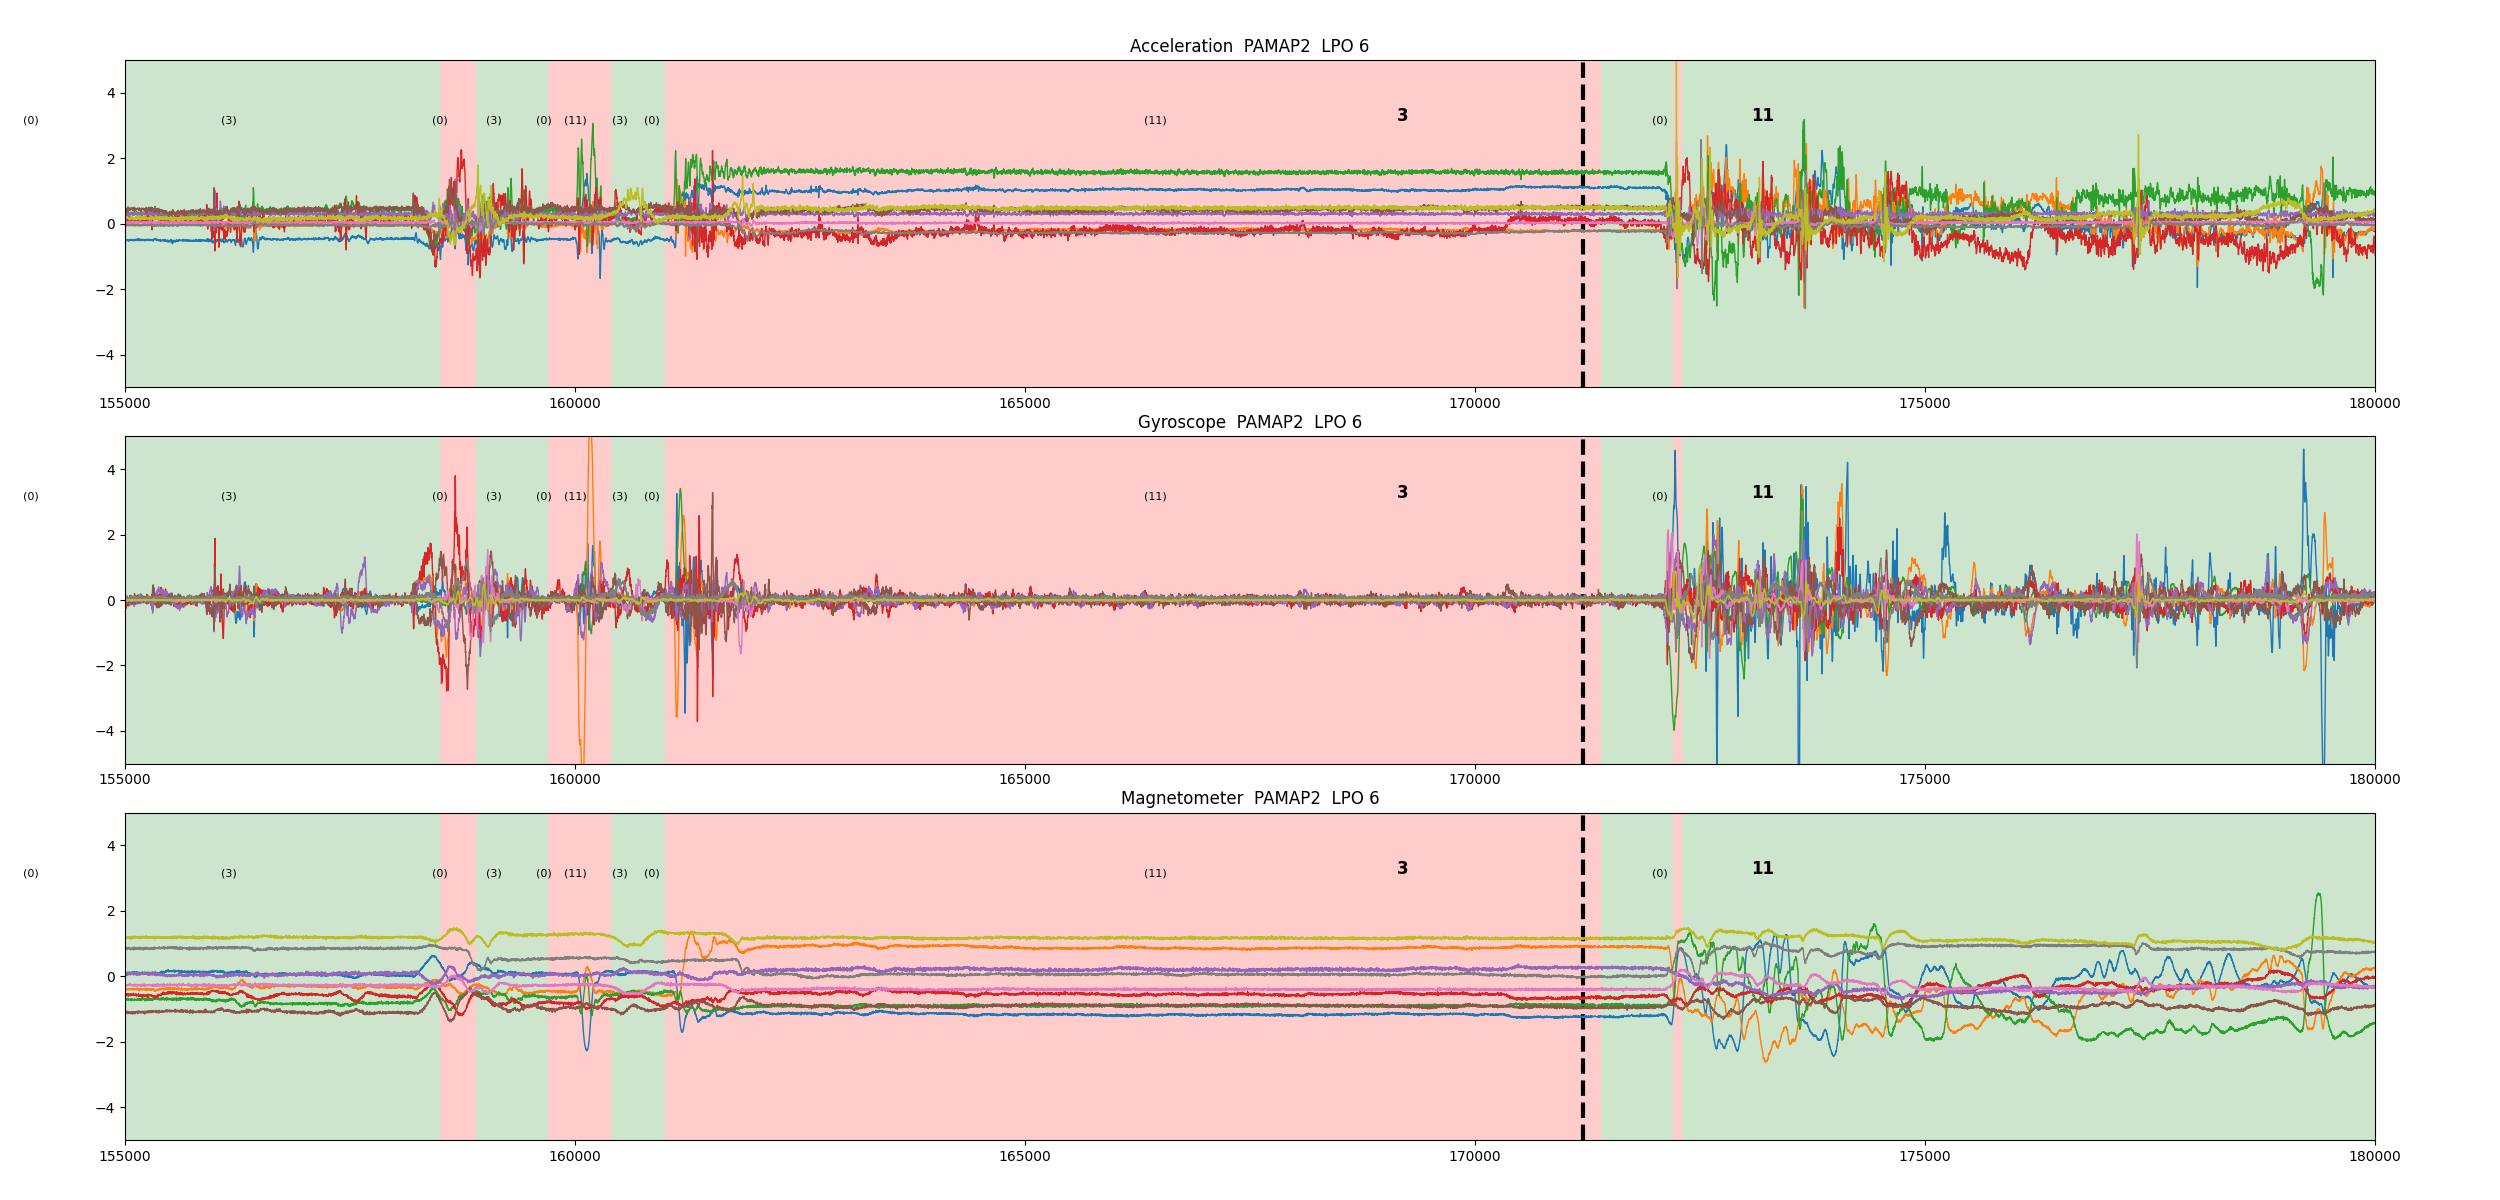

In [71]:
# PAMAP2 Labelling quality

%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
fig, axs = plt.subplots(3,1, figsize=(25, 12))

for ax_id,ax in enumerate(axs.flatten()):
    if ax_id in [0,1,2]:
        DATASET = 0
        PARTICIPANT = 4
    else:
        DATASET = 0
        PARTICIPANT = 6
    vis_data = data[DATASET][PARTICIPANT]
    # print(len(sensors))
    # result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

    # plt.bar(range(0,len(result_sum)),result_sum, width=1)

    # plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


    
    # max_val = np.max(result_sum)  
    # all_models = np.zeros_like(result_sum)
    # all_models[result_sum == max_val] = 1  

    segment_starts = []
    segment_ends = []

    vectors = vis_data["vec"]
    print(len(vectors))
    current_start = 0
    values = []
    values.append(vectors[0])
    for i in range(1, len(vectors)):
        if vectors[i] != vectors[i -1]:
            segment_starts.append(current_start)
            segment_ends.append((i+1)*WINDOW//2)
            current_start = (i+1)*WINDOW//2
            values.append(vectors[i])

    segment_starts.append(current_start)
    segment_ends.append((len(vectors) -1)*WINDOW//2)
    print(segment_starts)
    print(segment_ends)
    print(values)
    colors = ['green' if x == 0 else 'red' for x in values]
    for start, end, color in zip(segment_starts, segment_ends, colors):
        # plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
        ax.axvspan(start, end, facecolor=color, alpha=0.2)
        # if 'complete' not in model_labels_added:
        #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
        #     model_labels_added.add('complete')

    gt = vis_data['gt']
    previous = 0
    for i in range(len(gt) - 1):
        if gt[i] != gt[i + 1] or i ==len(gt)-2:
            if i*WINDOW//2 in range(155000,180000):
                ax.axvline(x=i*WINDOW//2, color='black', linestyle='--', linewidth=3)
                ax.text(i*WINDOW//2-2000, 3, f"3", va='bottom', ha='center', color='black', fontsize=12,weight='bold')
                ax.text(i*WINDOW//2+2000, 3, f"11", va='bottom', ha='center', color='black', fontsize=12,weight='bold')
            previous = i*WINDOW//2

    y = vis_data['y']
    # pprint(y[0:100])
    # pprint(vectors[0:100])
    # pprint(gt[0:100])
    previous = 0
    for i in range(len(y) - 1):
        if y[i] != y[i + 1]:
            #ax.vlines(x=i*WINDOW//2,ymin=10.25,ymax=10.75, color='black', linestyle='--', linewidth=0.5)
            ax.text(i*WINDOW//2-(i*WINDOW//2-previous)/2, 3, f"({y[i]})", va='bottom', ha='center', color='black', fontsize=8)
            previous = i*WINDOW//2

    x = vis_data['x']

    #PAMAP2
    if ax_id== 0 :
   
        indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]# acc
        ax.set_title("Acceleration "+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
    elif ax_id== 1 :
        indices = [3, 4, 5, 16, 17, 18, 29, 30, 31]# gyr
        ax.set_title("Gyroscope "+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
    else:
        indices = [6, 7, 8, 19, 20, 21, 32, 33, 34]# mag
        ax.set_title("Magnetometer "+' '+ str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))

    ax.plot(range(0, len(x)), x[:,indices], linewidth=1)
    
    ax.set_ylim(-5,5)
    if ax_id in [0,1,2]:
        ax.set_xlim(155000,180000)
    else:
        ax.set_xlim(180000,205000)
    
    



plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.15, wspace=0.05)
plt.savefig(f'images/data_view_{DATASET_LIST[DATASET]}_null_insert.png',bbox_inches='tight')
plt.show()